In [65]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import warnings
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import spacy
from spacy import displacy
warnings.filterwarnings("ignore")

In [66]:
df = pd.read_excel('../data/cleaned_labeled_dataset_2.xlsx')
df.head()

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies tepuk tangan meriah rektor mewajibkan ma...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,"memang bener memang, pendukung 01 goblok, pend..."
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,anies bersikap kritis kinerja prabowo dianggap...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn tni polri pegang sump...


In [67]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

text          0
label         0
clean_text    0
dtype: int64

In [68]:
df.drop(columns='text', inplace=True)
df.head()

,label,clean_text
0,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...
1,Politik,anies tepuk tangan meriah rektor mewajibkan ma...
2,Demografi,"memang bener memang, pendukung 01 goblok, pend..."
3,Politik,anies bersikap kritis kinerja prabowo dianggap...
4,Politik,anies baswedan harap asn tni polri pegang sump...


In [69]:
def get_top_words(df, n=3, stop_words=None):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    words_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi kata
        vectorizer = CountVectorizer(stop_words=stop_words)
        X = vectorizer.fit_transform(group['clean_text'])
        word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = word_freq.sum().sort_values(ascending=False)
        
        # Simpan n kata yang paling sering muncul dan frekuensinya
        words_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari kata-kata yang paling sering muncul
    features = set()
    for label, freq in words_freq.items():
        for word in freq.keys():
            features.add(word)

    features = list(features)

    return words_freq, features


# persentase kata yang paling sering muncul
def get_top_words_percentage(df, n=3, stop_words=None):
    words_freq, features = get_top_words(df, n, stop_words)

    grouped = df.groupby('label')

    words_percentage = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi kata
        vectorizer = CountVectorizer(stop_words=stop_words)
        X = vectorizer.fit_transform(group['clean_text'])
        word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = word_freq.sum().sort_values(ascending=False)
        
        # Hitung persentase kata yang paling sering muncul
        words_percentage[name] = (total_freq.nlargest(n) / total_freq.sum() * 100).to_dict()

    return words_percentage


def tokenize(text, stopwords):
    # Cari semua hashtag dan hapus stopwords
    return [word for word in re.findall(r"#(\w+)", text) if word not in stopwords]

def get_top_hashtags(df, n=3, stopwords=None):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    hashtags_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi hashtag
        vectorizer = CountVectorizer(tokenizer=lambda text: tokenize(text, stopwords))
        X = vectorizer.fit_transform(group['clean_text'])
        hashtag_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = hashtag_freq.sum().sort_values(ascending=False)
        
        # Simpan n hashtag yang paling sering muncul dan frekuensinya
        hashtags_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari hashtag yang paling sering muncul
    features = set()
    for label, freq in hashtags_freq.items():
        for hashtag in freq.keys():
            features.add(hashtag)

    features = list(features)

    return hashtags_freq, features

# NER (Named Entity Recognition) menggunakan Spacy


nlp = spacy.load('en_core_web_sm')

def get_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

def get_top_named_entities(df, n=3):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    entities_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi named entities
        entities = group['clean_text'].apply(get_named_entities)
        entities = pd.Series([ent for sublist in entities for ent in sublist])
        total_freq = entities.value_counts()
        
        # Simpan n named entities yang paling sering muncul dan frekuensinya
        entities_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari named entities yang paling sering muncul
    features = set()
    for label, freq in entities_freq.items():
        for entity in freq.keys():
            features.add(entity)

    features = list(features)

    return entities_freq, features


# sentimen analisis data bahasa indonesia menggunakan library Sastrawi dan TextBlob bahasa indonesia 


def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_top_sentiments(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    sentiments = {}

    for name, group in grouped:
        # Hitung sentimen
        sentiment = group['clean_text'].apply(get_sentiment)
        sentiments[name] = sentiment.mean()

    return sentiments




In [70]:
entities_freq, entities_features = get_top_named_entities(df, n=3)


print(entities_freq)
print(entities_features)

{'Demografi': {'indonesia': 8, '3': 6, 'ganjar-mahfud': 5}, 'Ekonomi': {'#': 73, 'ganjar pranowo': 70, '#ganjarpranowopilihanumat #': 48}, 'Geografi': {'jakarta': 4, '2024': 3, '3': 2}, 'Ideologi': {'indonesia': 96, 'ganjar pranowo': 93, '3': 79}, 'Pertahanan dan Keamanan': {'#': 49, 'indonesia': 44, 'januari': 36}, 'Politik': {'#': 537, 'indonesia': 309, 'ganjar pranowo': 249}, 'Sosial Budaya': {'#': 128, 'indonesia': 105, 'jakarta': 43}, 'Sumber Daya Alam': {'jakarta': 25, '#02melanjutkan #': 24, 'air hujan': 23}}
['#02melanjutkan #', '3', 'air hujan', '#ganjarpranowopilihanumat #', 'jakarta', '2024', 'januari', 'indonesia', '#', 'ganjar-mahfud', 'ganjar pranowo']


In [71]:
words_percentage = get_top_words_percentage(df, n=40)

# masukkan menjadi fitur ke dalam dataframe
for label, freq in words_percentage.items():
    for word, percentage in freq.items():
        df[f'{label}_{word}'] = df['clean_text'].str.contains(word).astype(int)

sentiments = get_top_sentiments(df) # n tidak digunakan

# masukkan menjadi fitur ke dalam dataframe
for label, sentiment in sentiments.items():
    df[f'{label}_sentiment'] = sentiment


In [72]:
# words_freq, features_kata = get_top_words(df, n=6, stop_words=['ganjar', 'anies', 'prabowo',
#                                                            'mahfud', 'pranowo', 'dalam',
#                                                              'ganjarpranowopilihanumat', 'ganjarmahfudrebound', 'ganjarmahfud2024',
#                                                              'indonesia', 'capres', 'gibran', 'md',
#                                                              'cawapres', 'presiden', 'jnk',
                                                             
#                                                              ])
# print(words_freq)
# print(features_kata)

In [73]:
words_freq, features_kata = get_top_words(df, n=40, stop_words=[
                                                             ])
# kalau pakai n 50 dia meningkat dari 75 ke 78
print(words_freq)
print(features_kata)

{'Demografi': {'anies': 43, 'ganjar': 39, 'prabowo': 21, 'mahfud': 20, 'anak': 17, 'muda': 16, 'kalangan': 14, 'etnis': 13, 'generasi': 12, 'gibran': 11, 'indonesia': 11, 'kalbar': 10, 'pendidikan': 9, 'jawa': 9, 'program': 8, 'keluarga': 8, 'menengah': 8, 'tokoh': 8, 'mas': 7, '02': 7, 'masyarakat': 7, 'adat': 7, 'banget': 7, 'gratis': 7, 'barat': 7, 'ganjarmahfud2024': 7, 'lain': 7, 'petani': 7, 'pranowo': 6, 'prajurit': 6, 'presiden': 6, 'desak': 6, '2024': 6, 'dalam': 6, 'mendukung': 6, 'rakyat': 5, 'rabu': 5, 'batak': 5, 'bhayangkara': 5, 'kota': 5}, 'Ekonomi': {'ganjar': 267, 'ekonomi': 170, 'pranowo': 166, 'mahfud': 158, 'jnk': 141, 'ganjarpranowopilihanumat': 140, 'md': 129, 'ganjarmahfudrebound': 124, 'capres': 122, 'prabowo': 112, 'program': 104, 'petani': 88, 'anies': 85, 'cawapres': 83, 'pasangan': 73, 'indonesia': 69, 'dalam': 65, 'nelayan': 59, 'pupuk': 53, 'pertanian': 51, 'gibran': 51, 'desa': 46, 'lahan': 45, 'mendukung': 45, 'prof': 44, 'food': 43, 'nomor': 43, 'estat

In [74]:
df['clean_text'].iloc[0]

'kunjungan prabowo meresmikan menyerahkan proyek bantuan air bersih titik. #indonesiasentris #indonesiahijau #02melanjutkan #anakmudaindonesiaemas prabowo subianto'

In [75]:
stopwords = []
hashtags_freq, features_hastag = get_top_hashtags(df, n=10, stopwords=stopwords)
print(hashtags_freq)
print(features_hastag)

{'Demografi': {'ganjarmahfud2024': 7, 'l3bihbaik': 3, '02melanjutkan': 2, 'indonesiahijau': 2, 'anakmudaindonesiaemas': 2, 'coblos3': 2, 'mahfudlebihbaik3': 2, 'indonesiasentris': 2, 'ganjarpresidenrakyat': 2, 'pdiperjuangan': 1}, 'Ekonomi': {'jnk': 141, 'ganjarpranowopilihanumat': 140, 'ganjarmahfudrebound': 124, 'ganjarmahfud2024': 27, 'rembuganjar': 19, 'l3bihbaik': 12, 'aminajadulu': 8, 'mahfudlebihbaik3': 8, 'gasssganjarmahfud': 7, 'ganjarmahfudm3nang': 7}, 'Geografi': {'ganjarmahfud2024': 1, 'hotlineparisamin': 1, 'l3bihbaik': 1, 'mahfudlebihbaik3': 1}, 'Ideologi': {'ganjarpranowopilihanumat': 143, 'jnk': 112, 'ganjarmahfudrebound': 101, 'ganjar': 25, 'ganjarmahfud2024': 25, 'menangseputaran': 24, 'l3bihbaik': 19, 'mahfudlebihbaik3': 14, 'mahfud': 8, 'ganjarmerawatpancasila': 6}, 'Pertahanan dan Keamanan': {'ganjarmahfud2024': 74, 'coblos3': 33, 'dulujokowisekarangganjar': 23, 'l3bihbaik': 20, 'debatcapres': 14, 'ganjarmahfudm3nangdebat': 12, '02melanjutkan': 11, 'pemilu2024': 8,

In [76]:
# tambahkan fitur ke dataframe dan isi dengan frekuensi hashtag
for feature in features_hastag:
    df[feature] = 0

for i, row in df.iterrows():
    for feature in features_hastag:
        df.at[i, feature] = row['clean_text'].count('#' + feature)
        

In [77]:
# tambahkan fitur ke dataframe dan isi dengan frekuensi kata
for feature in features_kata:
    df[feature] = 0

for i, row in df.iterrows():
    for feature in features_kata:
        df.at[i, feature] = row['clean_text'].count(feature)

df.head()

,label,clean_text,Demografi_anies,Demografi_ganjar,Demografi_prabowo,Demografi_mahfud,Demografi_anak,Demografi_muda,Demografi_kalangan,Demografi_etnis,...,menjaga,relawan,mas,air,dasar,nilai,martabat,islam,korban,serangan
0,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...,0,0,1,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,Politik,anies tepuk tangan meriah rektor mewajibkan ma...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Demografi,"memang bener memang, pendukung 01 goblok, pend...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Politik,anies bersikap kritis kinerja prabowo dianggap...,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Politik,anies baswedan harap asn tni polri pegang sump...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# total kolom df
print(df.columns)
print(len(df.columns))

Index(['label', 'clean_text', 'Demografi_anies', 'Demografi_ganjar',
       'Demografi_prabowo', 'Demografi_mahfud', 'Demografi_anak',
       'Demografi_muda', 'Demografi_kalangan', 'Demografi_etnis',
       ...
       'menjaga', 'relawan', 'mas', 'air', 'dasar', 'nilai', 'martabat',
       'islam', 'korban', 'serangan'],
      dtype='object', length=536)
536


In [79]:
# simpan ke file
df.to_excel('../data/feature_extracted_dataset.xlsx', index=False)

In [80]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

X = df.drop(columns=['label', 'clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)


0.4621927009544169

In [82]:
# seimbangkan dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# random forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.7855270666189722

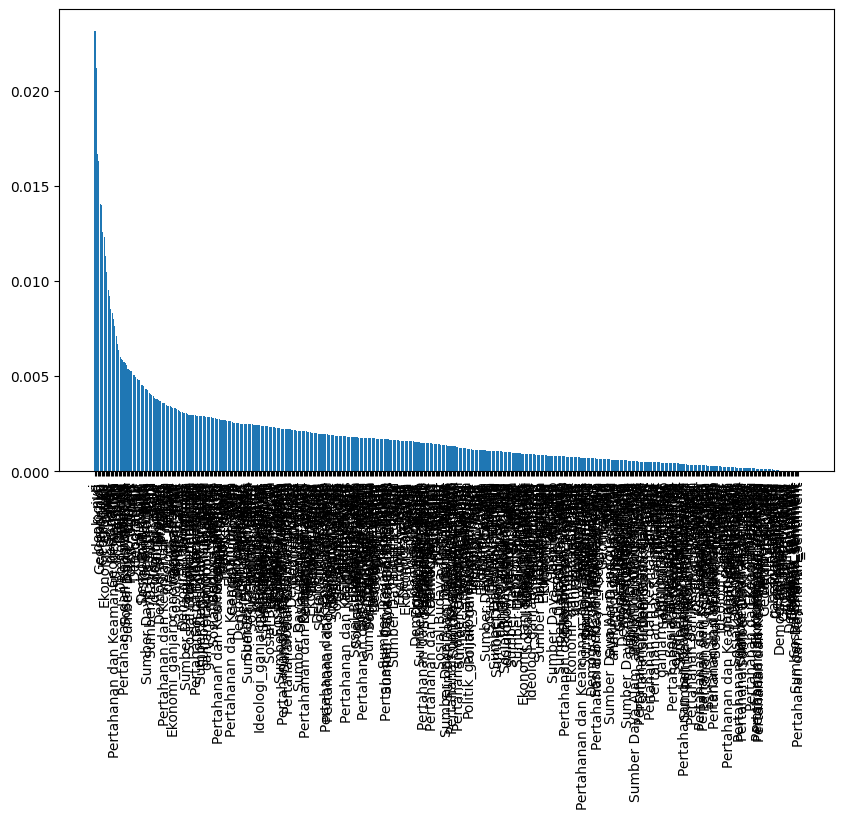

In [83]:
# feature importance
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()


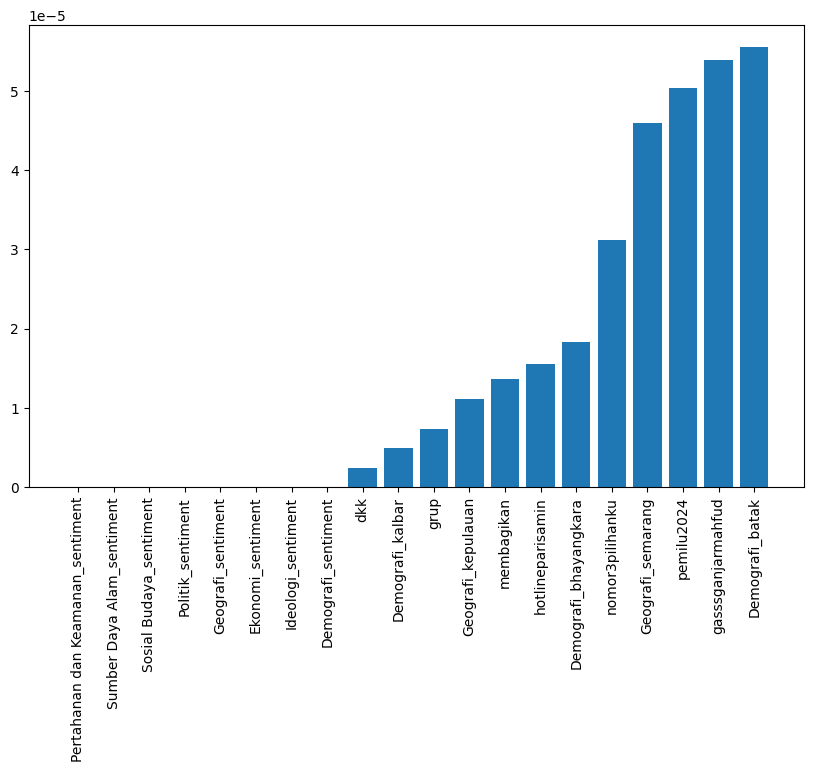

In [84]:
# 20 fitur terbawah
importances = clf.feature_importances_
indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.show()


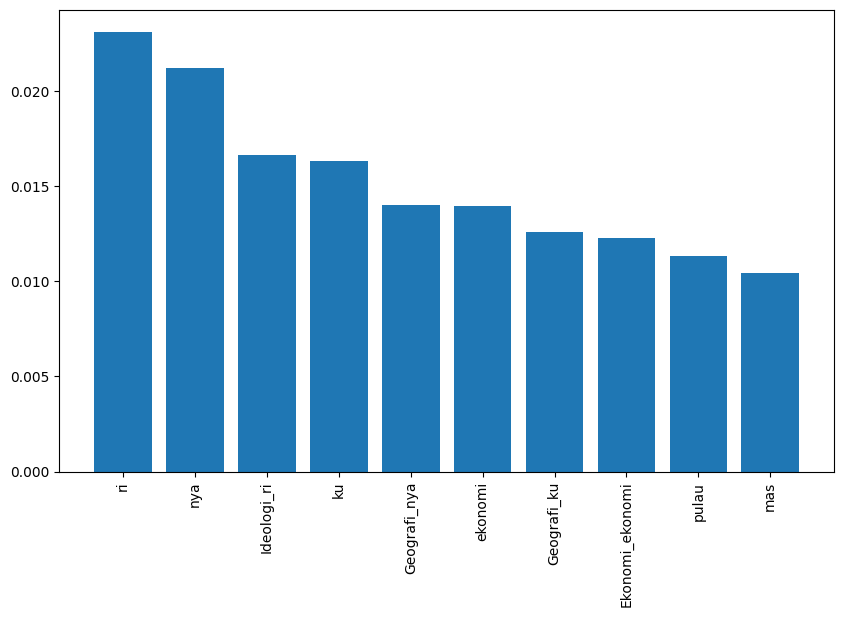

In [85]:
# 10 fitur teratas
importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X.columns[indices][:10], rotation=90)
plt.show()

In [86]:
unlabeled = pd.read_excel('../data/cleaned_unlabeled_dataset_2.xlsx')
unlabeled

,IDText,Text,clean_text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...
...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...","bikin bangga deh, ganjar-mahfud alokasikan bel..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi pilpres 2024 berbesar hati merangkul pr...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga ikutan debat deh..nga ma...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk bermusyawarah gaya kepemimp...


# INFERENCE

In [87]:

# ambil fitur kolom clean text pada unlabeled dataset

for feature in features_kata:
    unlabeled[feature] = 0

for i, row in unlabeled.iterrows():
    for feature in features_kata:
        unlabeled.at[i, feature] = row['clean_text'].count(feature)

for feature in features_hastag:
    unlabeled[feature] = 0

for i, row in unlabeled.iterrows():
    for feature in features_hastag:
        unlabeled.at[i, feature] = row['clean_text'].count('#' + feature)

unlabeled.columns

Index(['IDText', 'Text', 'clean_text', 'banget', 'suka', 'ri', 'reklamasi',
       'mendapatkan', 'sumur', 'abah',
       ...
       'gasssganjarmahfud', 'ganjarmahfudm3nangdebat', 'pdiperjuangan',
       'mahfudlebihbaik3', 'ganjarmerawatpancasila', 'ganjarsatset',
       'asalbukanprabowo', 'ganjaruntuksemua', 'ganjarmahfudm3nang',
       'ganjarpresidenrakyat'],
      dtype='object', length=209)

In [175]:
# prediksi
X_unlabeled = unlabeled.drop(columns=['clean_text', 'Text', 'IDText'])
y_unlabeled = clf.predict(X_unlabeled)

unlabeled['label'] = y_unlabeled
# hapus kolom fitur
unlabeled.drop(columns=X_unlabeled.columns, inplace=True)

unlabeled.head()

,IDText,Text,clean_text,label
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...,Pertahanan dan Keamanan
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...,Politik
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...,Ideologi
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat,Politik
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...,Ekonomi


In [179]:
template

,IDText;Kelas
0,TXT0001;NA
1,TXT0002;NA
2,TXT0003;NA
3,TXT0004;NA
4,TXT0005;NA
...,...
995,TXT0996;NA
996,TXT0997;NA
997,TXT0998;NA
998,TXT0999;NA


In [176]:
unlabeled['IDText;Kelas'] = unlabeled['IDText'] + ';' + unlabeled['label']

unlabeled.drop(columns=['IDText', 'Text', 'clean_text', 'label'], inplace=True)

unlabeled.head()

,IDText;Kelas
0,TXT0001;Pertahanan dan Keamanan
1,TXT0002;Politik
2,TXT0003;Ideologi
3,TXT0004;Politik
4,TXT0005;Ekonomi


In [178]:

unlabeled.to_csv('../data/predicted_dataset_.csv', index=False)